# Trabalho de TABD
todo. introdução


## Índice (todo)
1. [Preparação dos dados](#preparação)

2. [Análise geral da base de dados](#análise)
    1. [Análise da tabela tracks](#tracks)
    2. [Análise da tabela cont_aad_caop2018](#cont_aad_caop2018)
3. [Animação da epidemia](#epidemia)
    1. [No país](#pais)
    2. [Por distrito](#distrito)
    3. [Por concelho](#concelho)
4. ...



## Preparação dos dados <a name="preparação"></a>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import psycopg2
import math
import datetime
import csv
import time
from postgis import Polygon,MultiPolygon
from postgis.psycopg import register
import trab_functions as aux
from importlib import reload
from ipywidgets import widgets
from IPython.display import HTML, display
import osmnx as ox

### Definição de variáveis globais

In [2]:
""" Definição de algumas variáveis globais """
starttime=time.time()

DEBUG=True
OFFSETS_CSV='offsets3.csv'
EPIDEMIC_CSV='epidemic.csv'        #dist=50m, p=0.1
#EPIDEMIC_CSV='epidemicP10D10.csv' #dist=10m, p=0.1
DB_NAME='tracks'
DB_USER='nan'
INFECTED_COLOR=.2
NOT_INFECTED_COLOR=.3
step=90 #de 15 em 15 mins

### Estabelecer uma ligação com a base de dados

In [184]:
starttime=time.time()
  
conn = psycopg2.connect("dbname=%s user=%s" % (DB_NAME,DB_USER))
register(conn)
cursor_psql = conn.cursor()

if DEBUG : print("took %f seconds" % (time.time()-starttime))

took 0.028268 seconds


### Carregar o csv com os offsets

In [185]:
starttime=time.time()

OFFSETS = aux.read_offsets(OFFSETS_CSV)

if DEBUG : print("took %f seconds" % (time.time()-starttime))

took 38.353029 seconds


## Análise geral da base de dados <a name="análise"></a>

### 2.1 Tabela Tracks  <a name="tracks"></a>

#### 2.1.1. Número de taxis

In [180]:
starttime=time.time()

cursor_psql.execute('''
                    SELECT COUNT(DISTINCT taxi) 
                    FROM tracks
                    ''')
results = cursor_psql.fetchall()
n_taxis= int(results[0][0])
n_taxis

if DEBUG : print("took %f seconds" % (time.time()-starttime))

took 1.634099 seconds


#### 2.1.2. Mostrar numero de trajetos que iniciaram a sua marcha a partir de que distritos

In [181]:
starttime=time.time()

cursor_psql.execute('''
                    SELECT distrito, count(*) 
                    FROM cont_aad_caop2018, tracks 
                    WHERE st_within(st_startpoint(proj_track),proj_boundary)
                    GROUP BY distrito ORDER BY 2 desc
                    '''
)
results  = cursor_psql.fetchall()
#fields = tuple([field[0] for field in cursor_psql.description])
#results.insert(0,fields)

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
       )
))

if DEBUG : print("took %f seconds" % (time.time()-starttime))

LISBOA,47945
PORTO,33835
COIMBRA,14127
BRAGA,4129
AVEIRO,2062
SETÚBAL,134
SANTARÉM,19
FARO,5
VIANA DO CASTELO,4
LEIRIA,1


took 8.767102 seconds


#### 2.1.3. Mostrar numero de trajectos que terminaram a sua marcha em que distritos

In [182]:
starttime=time.time()

cursor_psql.execute('''
                    SELECT distrito, count(*) 
                    FROM cont_aad_caop2018, tracks 
                    WHERE st_within(st_endpoint(proj_track),proj_boundary)
                    GROUP BY distrito 
                    ORDER BY 2 desc
                    '''
)
fields = tuple([field[0] for field in cursor_psql.description])
results  = cursor_psql.fetchall()
results.insert(0,fields)

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
       )
))

if DEBUG : print("took %f seconds" % (time.time()-starttime))

distrito,count
LISBOA,47951
PORTO,33830
COIMBRA,14128
BRAGA,4132
AVEIRO,2065
SETÚBAL,125
SANTARÉM,19
FARO,5
VIANA DO CASTELO,3


took 5.527940 seconds


### 2.2 Tabela cont_aad  <a name="cont_aad_caop2018"></a>

#### TODO

## 3. Animação no mapa de Portugal (todo: mudar estes títulos)  <a name="simulação"></a>

texto explicativo. todo

### Carregar o csv com a epidemia

In [163]:
starttime=time.time()

""" Ler os dados da epidemia para um array """
def read_csv(csv_file):
    array = []
    with open(csv_file, 'r') as csvFile:
        reader = csv.reader(csvFile)
        i = 0
        for row in reader:
            l = []
            for j in row:
                l.append(float(j))
            array.append(l)
    return np.array(array)


infected= read_csv(EPIDEMIC_CSV)

if DEBUG: print("took %f seconds" % (time.time()-starttime))

took 4.443613 seconds


### Calcular os histogramas

In [165]:
starttime = time.time()
step=90 #de 15 em 15 minutos

INFECTED=1
NOT_INFECTED=0
RECOVERED=2

def within(point):
    if (point[0]==0 and point[1]==0):
        return "NOT_ACTIVE"
    
    query='''
        SELECT distrito 
        FROM cont_aad_caop2018
        WHERE st_within(ST_SetSRID(ST_Point( %f, %f), 3763), proj_boundary)
    ''' % (point[0],point[1])
    cursor_psql.execute(query)
    results = cursor_psql.fetchall()
    
    if (not results):
        return "OTHER"
    return str(results[0][0])

def get_hist(step,distritos):
    hist_x=[]
    hist_y_inf={}

    n_inf={}
    n_portugal=0
    n_inf={}
    hist_y_inf={}    
    
    #inicializar os dicionarios
    for d in distritos:
        n_inf[d]={}
        hist_y_inf[d]={}   
        for state in ["infected","susceptible","recovered","total"]:
            n_inf[d][state]=0       
            hist_y_inf[d][state]=[]
            
    for r in range(1,len(infected),step):
        for d in distritos:
            for state in ["infected","susceptible","recovered","total"]:
                n_inf[d][state]=0              

        for c in range(0, len(infected[r])):
            DISTRITO= within(OFFSETS[r][c])
            
            if(infected[r][c]==INFECTED):
                state="infected"
            elif(infected[r][c]==NOT_INFECTED):
                state="susceptible"
            else:
                state="recovered"
                      
            if (DISTRITO in distritos):
                n_inf[DISTRITO][state]+=1
                n_inf[DISTRITO]["total"]+=1
            
            if (DISTRITO != "NOT_ACTIVE"):
                n_inf["PORTUGAL"][state]+=1
                n_inf["PORTUGAL"]["total"]+=1

        hist_x.append(step+r)
        
        for d in distritos:
            for state in ["infected","susceptible","recovered","total"]:
                hist_y_inf[d][state].append(n_inf[d][state])
    
    hist_y_inf_perc={}
    for d in distritos:
        hist_y_inf_perc[d]={}       
        for state in ["infected","susceptible","recovered","total"]:
            hist_y_inf_perc[d][state]=list(map(lambda x, y : (x/y) *100 if y>0 else 0, hist_y_inf[d][state], hist_y_inf[d]["total"]))
            hist_y_inf[d][state]=np.array(hist_y_inf[d][state])
            hist_y_inf_perc[d][state]=np.array(hist_y_inf_perc[d][state])
            
    return (hist_x,hist_y_inf,hist_y_inf_perc)

distritos=["PORTO","LISBOA","PORTUGAL"]
hist_x,hist_y_inf,hist_y_inf_perc = get_hist(step,distritos)

if DEBUG: print("took %d seconds" % (time.time()-starttime))    

took 10 seconds


In [178]:
hist_y_inf

{'PORTO': {'infected': array([  0,   1,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,
           0,   0,   1,   1,   1,   1,   1,   1,   0,   1,   1,   1,   1,
           1,   0,   0,   1,   4,   5,  16,  37,  98, 173, 265, 282, 309,
         347, 340, 343, 335, 334, 359, 401, 365, 375, 424, 406, 410, 409,
         393, 386, 399, 384, 391, 398, 379, 375, 396, 401, 396, 374, 396,
         415, 403, 382, 387, 357, 370, 342, 353, 357, 329, 312, 311, 293,
         250, 262, 256, 249, 230, 230, 210, 204, 210, 180, 185, 189, 171,
         159, 186, 160, 146, 126]),
  'susceptible': array([  0,  63,  72,  77,  63,  72,  70,  78,  70,  69,  86,  81,  85,
          78,  94,  95,  90,  90,  85,  85,  88,  91, 105, 121, 128, 160,
         177, 238, 261, 331, 337, 362, 368, 346, 301, 225, 152,  94,  71,
          62,  41,  38,  32,  25,  26,  20,  11,  11,  12,  10,   7,   7,
          10,   7,   4,   5,   7,   3,   3,   4,   2,   4,   3,   3,   3,
           4,   2,   3,   1,   3,   2,  

In [179]:
hist_y_inf_perc

{'PORTO': {'infected': array([  0.        ,   1.5625    ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   1.26582278,
           1.4084507 ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   1.04166667,
           1.0989011 ,   1.0989011 ,   1.1627907 ,   1.1627907 ,
           1.12359551,   0.        ,   0.94339623,   0.81967213,
           0.7751938 ,   0.62111801,   0.56179775,   0.        ,
           0.        ,   0.30120482,   1.17302053,   1.36239782,
           4.16666667,   9.66057441,  24.56140351,  43.46733668,
          63.54916067,  75.        ,  81.31578947,  84.84107579,
          89.23884514,  90.02624672,  91.28065395,  93.0362117 ,
          93.24675325,  95.24940618,  97.07446809,  97.15025907,
          97.24770642,  97.59615385,  98.32134293,  98.31730769,
          97.51861042,  98.21882952,  99.00744417,  98.71465296,
          98.24120603,  99.25187032,  99.21465969,  98.94459103,
    

### Função auxiliar para mostrar os poligonos de cada distrito

In [156]:
def show_map(results,map_plot):
    xs, ys = [],[]
    for row in results:
        geom = row[1]
        if type(geom) is MultiPolygon:
            for pol in geom:
                xys = pol[0].coords
                xs, ys = [],[]
                for (x,y) in xys:
                    xs.append(x)
                    ys.append(y)
                map_plot.plot(xs,ys,color='black',lw='0.2')
        if type(geom) is Polygon:
            xys = geom[0].coords
            xs, ys = [],[]
            for (x,y) in xys:
                xs.append(x)
                ys.append(y)
            map_plot.plot(xs,ys,color='black',lw='0.2')
        

### Mostrar a animação <a name="animação_país"></a>

<IPython.core.display.Javascript object>


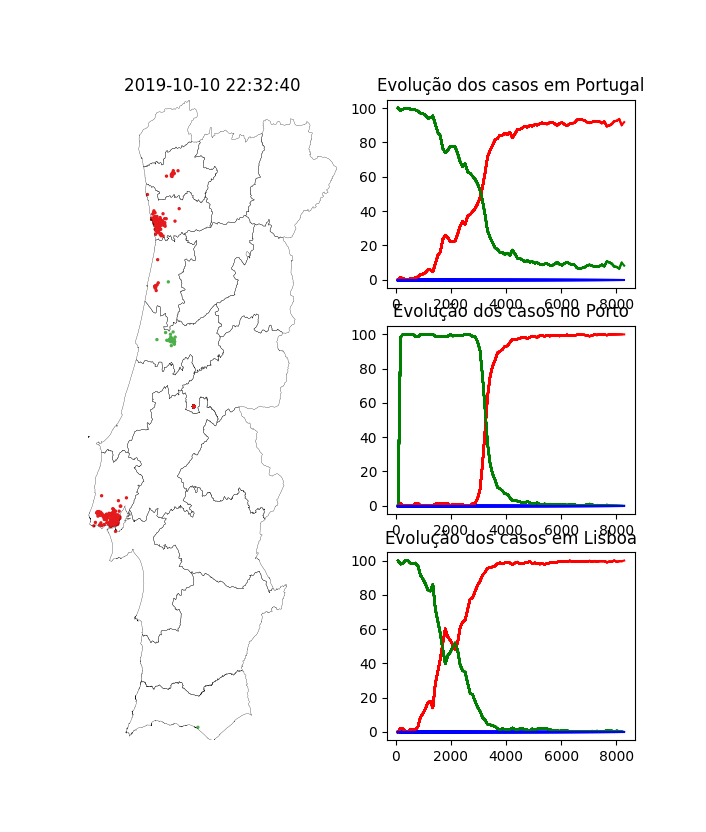

took 33 seconds


In [133]:
%matplotlib notebook

starttime=time.time()

query = '''
        SELECT  min(st_xmin(proj_boundary)) as xmin, 
                max(st_xmax(proj_boundary)) as xmax, 
                min(st_ymin(proj_boundary)) as ymin, 
                max(st_ymax(proj_boundary)) as ymax 
        FROM cont_aad_caop2018
        '''

cursor_psql.execute(query)
results = cursor_psql.fetchall()

xs_min, xs_max, ys_min, ys_max = results[0][0], results[0][1], results[0][2], results[0][3]
width_in_inches  = (xs_max-xs_min)/0.0254*1.1
height_in_inches = (ys_max-ys_min)/0.0254*1.1

scale=1/3000000
ts_i= 1570665600

fig= plt.figure(figsize=(width_in_inches*scale +3 , height_in_inches*scale)) 

gs = gridspec.GridSpec(3, 2)
pt_map1 = plt.subplot(gs[0:3, 0])
pt_map1.axis('off')
pt_map1.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))

portugal1 = plt.subplot(gs[0, 1])
portugal1.set_title("Evolução dos casos em Portugal")

porto = plt.subplot(gs[1, 1])
porto.set_title("Evolução dos casos no Porto")

lisboa = plt.subplot(gs[2, 1])
lisboa.set_title("Evolução dos casos em Lisboa")

fig.add_subplot(pt_map1) 
fig.add_subplot(portugal1) 
fig.add_subplot(porto) 
fig.add_subplot(lisboa)

xx,yy=[],[]
for i in OFFSETS[0]:
    xx.append(i[0])
    yy.append(i[1])

    
green, red=.2, .5
num_taxis=len(OFFSETS[0])
half=int(num_taxis/2)
rest=num_taxis-half

#mapear as cores - infectado (1) para .3 (vermelho), não infectado(0) para .2 (verde)
color_data=[]
for r in infected:
    color_data.append([INFECTED_COLOR if c==INFECTED else NOT_INFECTED_COLOR for c in r])
color_data = np.array(color_data)
    
colors1, colors2 = np.full(half,green), np.full(rest,red)
colors = [*colors1,*colors2]    
scat = pt_map1.scatter(xx,yy,c=colors,s=2, cmap=mpl.cm.Set1)

query = '''
            SELECT distrito, st_union(proj_boundary) 
            FROM cont_aad_caop2018 
            GROUP BY distrito
        '''

cursor_psql.execute(query)
results = cursor_psql.fetchall()

show_map(results,pt_map1)
index_i=1

def animate(i, color_data, scat, hist_x, hist_y_inf):
    pt_map1.set_title(datetime.datetime.utcfromtimestamp(ts_i+i*10))   
    global index_i
    

    if(i%90==0): #de 15 em 15 mins
        portugal1.plot(hist_x[0:index_i],hist_y_inf_perc["PORTUGAL"]["infected"][0:index_i],color='red')
        portugal1.plot(hist_x[0:index_i],hist_y_inf_perc["PORTUGAL"]["susceptible"][0:index_i],color='green')
        portugal1.plot(hist_x[0:index_i],hist_y_inf_perc["PORTUGAL"]["recovered"][0:index_i],color='blue')

        porto.plot(hist_x[0:index_i],hist_y_inf_perc["PORTO"]["infected"][0:index_i],color='red')
        porto.plot(hist_x[0:index_i],hist_y_inf_perc["PORTO"]["susceptible"][0:index_i],color='green')
        porto.plot(hist_x[0:index_i],hist_y_inf_perc["PORTO"]["recovered"][0:index_i],color='blue')

        lisboa.plot(hist_x[0:index_i],hist_y_inf_perc["LISBOA"]["infected"][0:index_i],color='red')
        lisboa.plot(hist_x[0:index_i],hist_y_inf_perc["LISBOA"]["susceptible"][0:index_i],color='green')
        lisboa.plot(hist_x[0:index_i],hist_y_inf_perc["LISBOA"]["recovered"][0:index_i],color='blue')
                    
        index_i+=1

    scat.set_array(color_data[i])
    scat.set_offsets(OFFSETS[i])

    
anim = FuncAnimation(fig, animate, interval=10, frames=len(OFFSETS)-1, repeat = False, fargs=(color_data,scat, hist_x,hist_y_inf))

plt.show()

if DEBUG: print("took %d seconds" % (time.time()-starttime))

## Animação da epidemia em diferentes distritos <a name="animação_distrítos"></a>

### Seleccionar um Distrito, intervalo de tempo e escala

In [153]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#query para obter distritos
query = '''
        SELECT DISTINCT distrito 
        FROM cont_aad_caop2018
        ORDER BY 1 asc
        '''
cursor_psql.execute(query)
results  = cursor_psql.fetchall()
distritos = [d[0] for d in results]

distritos_menu = widgets.Dropdown(value=distritos[0],options=distritos,description='Distrito')
horas_slider = widgets.IntRangeSlider(value=(10, 14), min=0, max=23, step=1, description='Intervalo (h)')
escala_slider = widgets.IntSlider(description='Escala: 1/', value=1800605, min=300000, max=3000000)

widgets.VBox([distritos_menu,horas_slider,escala_slider])

### Mostrar a animação

<IPython.core.display.Javascript object>


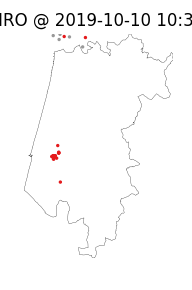

took 1 seconds


In [170]:
%matplotlib notebook

""" Carregar os valores de input """
distrito=distritos_menu.value
(hora_inicial, hora_final) = horas_slider.value
scale=1/escala_slider.value

starttime=time.time()

#Obter o poligono do distrito
query='''
        select 
            distrito, st_union(proj_boundary) as pol, 
            min(st_xmin(proj_boundary)) as xmin, 
            max(st_xmax(proj_boundary)) as xmax, 
            min(st_ymin(proj_boundary)) as ymin, 
            max(st_ymax(proj_boundary)) as ymax 
        from cont_aad_caop2018 where distrito='%s'
        group by distrito
 ''' % distrito


cursor_psql.execute(query)
results  = cursor_psql.fetchall()

xs_min, xs_max, ys_min, ys_max = results[0][2], results[0][3], results[0][4], results[0][5]
width_in_inches  = (xs_max-xs_min)/0.0254*1.1
height_in_inches = (ys_max-ys_min)/0.0254*1.1

ts_hora_i = ts_i+3600*hora_inicial
ts_hora_f = ts_i+3600*hora_final

fig= plt.figure(figsize=(width_in_inches*scale , height_in_inches*scale)) 

gs = gridspec.GridSpec(1, 1)

mapa_distrito = plt.subplot(gs[0, 0])
mapa_distrito.axis('off')
mapa_distrito.set(xlim=(xs_min, xs_max), ylim=(ys_min, ys_max))


fig.add_subplot(mapa_distrito) 

show_map(results,mapa_distrito)

green, red=.2, .5
num_taxis=len(OFFSETS[0])
half=int(num_taxis/2)
rest=num_taxis-half

colors1, colors2 = np.full(half,green), np.full(rest,red)

colors = [*colors1,*colors2]

xx,yy=[],[]
for i in OFFSETS[0]:
    xx.append(i[0])
    yy.append(i[1])

scat = mapa_distrito.scatter(xx,yy,c=colors,s=2, cmap=mpl.cm.Set1)

def animate(i, color_data, scat,ts_hora_i,hora_inicial,hora_final):
    mapa_distrito.set_title(distrito + " @ " + str(datetime.datetime.utcfromtimestamp(ts_hora_i+i*10)))

    if(i>=(hora_final-hora_inicial)*360):
        anim.event_source.stop()
    scat.set_array(color_data[i+hora_inicial*360])
    scat.set_offsets(OFFSETS[i+hora_inicial*360])
    
    points = [[-50000, 100000], [-40000, 110000], [8, 4]]
    plt.Polygon(points)


anim = FuncAnimation(fig, animate, interval=100, frames=len(OFFSETS)-1, repeat = False, blit=False, fargs=(infected,scat,ts_hora_i,hora_inicial,hora_final))

start_button = widgets.Button(description='Start',disabled=False,button_style='success',icon='play')
pause_button = widgets.Button(description='Pause',disabled=False,button_style='info',icon='pause')
zoom_in_button = widgets.Button(description='Zoom_in',disabled=False,button_style='info',icon='zoom')
zoom_out_button = widgets.Button(description='Zoom_out',disabled=False,button_style='info',icon='zoom')

def event(button):
    anim.event_source.start() if button.description=='Start' else anim.event_source.stop()

def zoom_event(button):
    global scale
    if button.description=="Zoom_in":
        scale+=1/10000000
    else:
        scale-=1/10000000
    fig.set_size_inches(width_in_inches*scale, height_in_inches*scale, forward=True)


if DEBUG: print("took %d seconds" % (time.time()-starttime))   
    

start_button.on_click(event)
pause_button.on_click(event)
zoom_in_button.on_click(zoom_event)
zoom_out_button.on_click(zoom_event)
widgets.HBox([start_button, pause_button,zoom_in_button, zoom_out_button])


## Animação em concelhos específicos <a name="animação_concelhos"></a>

In [174]:
"""
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#query para obter distritos
query = '''
        SELECT DISTINCT distrito 
        FROM cont_aad_caop2018
        ORDER BY 1 asc
        '''
cursor_psql.execute(query)
results  = cursor_psql.fetchall()
distritos = [d[0] for d in results]

distritos_menu = widgets.Dropdown(value=distritos[0],options=distritos,description='Distrito')
horas_slider = widgets.IntRangeSlider(value=(10, 14), min=0, max=23, step=1, description='Intervalo (h)')
widgets.VBox([distritos_menu,horas_slider])
"""



"\nfrom __future__ import print_function\nfrom ipywidgets import interact, interactive, fixed, interact_manual\nimport ipywidgets as widgets\n\n#query para obter distritos\nquery = '''\n        SELECT DISTINCT distrito \n        FROM cont_aad_caop2018\n        ORDER BY 1 asc\n        '''\ncursor_psql.execute(query)\nresults  = cursor_psql.fetchall()\ndistritos = [d[0] for d in results]\n\ndistritos_menu = widgets.Dropdown(value=distritos[0],options=distritos,description='Distrito')\nhoras_slider = widgets.IntRangeSlider(value=(10, 14), min=0, max=23, step=1, description='Intervalo (h)')\nwidgets.VBox([distritos_menu,horas_slider])\n"

### Escolher um concelho específico

In [175]:
distrito=distritos_menu.value
(hora_inicial, hora_final) = horas_slider.value

#query para obter concelhos
query = '''
        SELECT DISTINCT concelho, distrito 
        FROM cont_aad_caop2018
        WHERE distrito='%s'
        ORDER BY 1 asc
        ''' % (distrito)
cursor_psql.execute(query)
results  = cursor_psql.fetchall()
concelhos = [c[0] for c in results]

concelhos_menu = widgets.Dropdown(value=concelhos[0],options=concelhos,description='Concelho')
widgets.VBox([concelhos_menu])

### Gerar o mapa do concelho usando a biblioteca osmnx

In [176]:
''' Criar o mapa do concelho'''
import matplotlib.pyplot as plt
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
ox.config(log_console=True, use_cache=True)
ox.__version__
ts_i= 1570665600

starttime = time.time()

concelho=concelhos_menu.value

''' query para obter o centroide e distancia maxima ao centroide num concelho'''
query = '''
         SELECT  st_astext(st_transform(centroid,4236)) as centroid, 
                 st_maxdistance(centroid,pol) as dist 
         FROM
         (
                SELECT pol, st_centroid(pol) as centroid
                    FROM (
                        SELECT concelho, st_union(proj_boundary) as pol 
                        FROM cont_aad_caop2018
                        WHERE concelho='%s'
                        GROUP BY concelho
                    ) as foo
        ) as foo2
        ''' % (concelho)
cursor_psql.execute(query)
results = cursor_psql.fetchall()
point = results[0][0]

lon,lat = point[len('POINT('):-1].split(" ") #remove a substring POINT( no inicio da string e ) do fim da string
lat = float(lat)
lon = float(lon)
distance = float(results[0][1])

starttime=time.time()

G = ox.graph_from_point((lat,lon),distance=distance)

if DEBUG : print(time.time()-starttime)

35.85378122329712


### Mostrar a animação no concelho

<IPython.core.display.Javascript object>


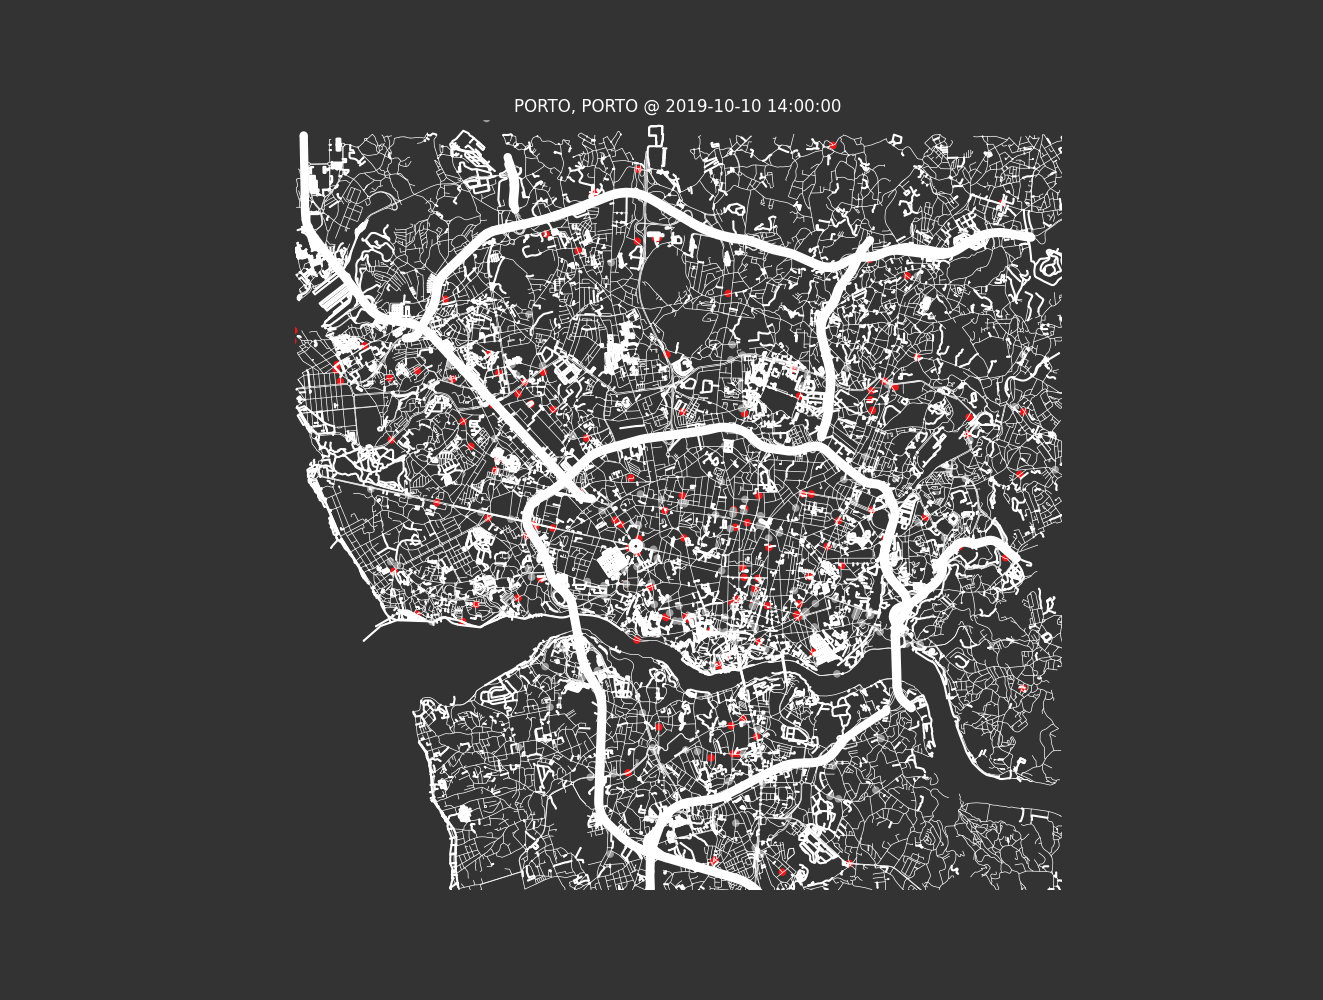

18.311140060424805
18.57913327217102


In [31]:
''' mostrar a animação no concelho'''

%matplotlib notebook

starttime=time.time()


fig, ax = ox.plot_figure_ground(G,default_width=.5,network_type='drive',fig_length=10, dist=distance,show=False, close=False)


ts_hora_i = ts_i+3600*hora_inicial
ts_hora_f = ts_i+3600*hora_final

i=0

index1= 360*hora_inicial
index2=360*hora_final
starttime=time.time()
count_e=0
count_n=0

#converter as coordenadas projectadas no sistema 3763 (como estão na nossa bd e no offsets)
#para o 4326 (mais comum e usado)
import pyproj
proj = pyproj.Transformer.from_crs(3763, 4326, always_xy=True) 

offsets_4326 = []

for r in range(index1,index1+1800):
    tmp=[]
    for c in range(0,len(OFFSETS[r])):
        if (OFFSETS[r][c][0]!=0):
            lat,lon = proj.transform(OFFSETS[r][c][0], OFFSETS[r][c][1])
            tmp.append([lat,lon])
        else:
            tmp.append(OFFSETS[r][c])
    offsets_4326.append(tmp)

print(time.time()-starttime)

green, red=.2, .5
num_taxis=len(OFFSETS[0])
half=int(num_taxis/2)
rest=num_taxis-half

colors1, colors2 = np.full(half,green), np.full(rest,red)
colors = [*colors1,*colors2]

xx,yy=[],[]
for i in offsets_4326[0]:
    xx.append(i[0])
    yy.append(i[1])
scat = ax.scatter(xx, yy, marker='o', c=colors,s=20, cmap=mpl.cm.Set1)


def animate(i,color_data,scat,offsets_4326,ts_hora_i,hora_inicial,hora_final):
    
    ax.set_title(concelho + ", " + distrito + " @ " + str(datetime.datetime.utcfromtimestamp(ts_hora_i+i*10)),color="white")

    if(i>=(hora_final-hora_inicial)*360):
        anim.event_source.stop()
    scat.set_offsets(offsets_4326[i])
    scat.set_array(color_data[i+hora_inicial*360])


anim = FuncAnimation(fig, animate, interval=10, frames=len(offsets_4326)-1, repeat = False,fargs=[infected,scat,offsets_4326,ts_hora_i,hora_inicial,hora_final])
if DEBUG : print(time.time()-starttime)

# TODO

1. Melhorar/simplificar o código em geral
2. ~~verificar se o codigo que gera os histogramas está a funcionar direito~~
- ~~corrigir os bugs na parte de mostrar os histogramas hora a hora dos infectados no porto e em lisboa~~ de 15 em 15 minutos
- corrigir as proporções do mapa de portugal. a grid desconfigura-o
- ~~Corrigir o bug na criação da epidemia - está a considerar taxis noutros concelhos próximos de lisboa ou do porto (ex. Maia) como geradores da epidemia, devem ser apenas taxis do porto ou de lisboa (ler o array com os offsets linha a linha, cada coluna que seja diferente de 0 0 é um taxi que iniciou atividade, fazer uam query com essas coordenadas, se for do porto adicionar [linha,coluna] ao array do porto, se for de lisboa adicionar ao array de lisboa, até que o array do porto fique preenchido com os 10 primeiros taxis e o de lisboa igual)~~ Feito
- ~~gerar uma outra epidemia para comparar com a que está, talvez diminuindo a probabilidade de contagio, de forma a termos uma epidemia que cresca menos~~
- ~~Ver a questão das cores na animação dos infectados por concelho. não está a funcionar ~~
- adicionar comentários
- adicionar capacidade de ~~parar, retomar ~~ e ir para tŕas no tempo na animação dos concelhos
- adicionar capacidade de parar, retomar e ir para tŕas no tempo na animação dos concelhos
- ~~adicionar os histogramas do porto e de lisboa~~
- marcar os sitios onde ocorreram infecções (sugestão do prof)
- deixar um lastro que faz o caminho: scatter + line plot (sugestão do prof)
- Fazer uma análise superficial da tabela cont_aad


# Algumas tarefas que me fui lembrando

1. Animação dos poligonos à volta dos infectados no porto, em lisboa e no pais. actualizar o gráfico com a área desses poligonos, ou assim
* Animação "on the fly", ir gerando a epidemia e mostrar os dados "em tempo real", com os critérios de distancia e probabilidade de infecao a poderem ser fornecidos pelo utilizador. Se houver tempo
* ~~Permitir escolher um concelho e ver a animação apenas nesse concelho,~~ assim como o histograma com o numero dos infectados apenas desse concelho
* ~~Incorporar dados do google maps~~ (openstreetmaps em vez de google maps)
* Simular uma epidemia em que após x tempo os taxis recuperam, tornam-se imunes, deixam de contaminar e mudam para outra cor. ~~adicionar ao histograma o numero de recuperados~~
* Adicionar uma espécie de "lastro" no percurso dos taxis infectados, que se vai desvanecendo com o tempo. Acho que era capaz de ficar engraçado
- adicionar o poligono do concelho por cima do mapa do concelho, para demarcar os limites do concelho. se houver tempo
- marcar os pontos onde se deu o contágio com uma cor diferente
- mapear as freguesias onde houve mais contágios
- adicionar texturas ao mapa de portugal, mas não sei como fazer
- instalar uma extensão no notebook que permita fazer toggle dos blocos de código e mostrar apenas o texto e o output do código

# Outras coisas, testes, etc (todelete)

In [19]:
%matplotlib notebook

""" desenhar os poligonos """

#obter os pontos num dado timestamp
lst=[p for p in OFFSETS[3000] if p[0]!=0]
lst.append(lst[0]) #adicionar o primeiro ponto ao fim da fila para "fechar" a linestring
print(len(lst))
str_points=""
for p in lst:
    str_points += str(p[0]) + " " + str(p[1]) + ","
str_points=str_points[:-1] #remover virgula final

query = '''
    SELECT st_area(pol)/1000000 as area, 
        st_perimeter(pol)/1000 as permiter, 
        st_astext(st_minimumboundingcircle(pol)) as circulo_minimo, 
        st_astext(st_orientedenvelope(pol)) as or_envelope, 
        st_astext(st_simplify(pol,1)) as octagon, 
        st_astext(st_envelope(pol)),
        st_astext(st_convexhull(pol)) as hull,
        pol,
        st_npoints(pol)
    FROM (
        SELECT st_astext(ST_MakePolygon( ST_GeomFromText('LINESTRING(%s)'))) as pol
        ) as foo
        ''' % (str_points)
cursor_psql.execute(query)
results = cursor_psql.fetchall()
hull = results[0][6]

p1 = [point for point in hull.split(",")]
p1[0]=p1[0][9:-1] #remove "POLYGON substring"
p1[len(p1)-1] = p1[len(p1)-1][0:-2]
px,py = [point.split(" ")[0] for point in p1], [point.split(" ")[1] for point in p1]

scat.set_offsets(OFFSETS[i])


plt.show()

if DEBUG: print("took %d seconds" % (time.time()-starttime))

1032


Traceback (most recent call last):
  File "/usr/local/lib64/python3.7/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib64/python3.7/site-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


TypeError: list indices must be integers or slices, not list

In [ ]:
""" desenhar os poligonos """

#obter os pontos num dado timestamp
lst=[p for p in OFFSETS[3000] if p[0]!=0] 
lst.append(lst[0]) #adicionar o primeiro ponto ao fim da fila para "fechar" a linestring
print(len(lst))
str_points=""
for p in lst:
    str_points += str(p[0]) + " " + str(p[1]) + ","
str_points=str_points[:-1] #remover virgula final

query = '''
    SELECT st_area(pol)/1000000 as area, 
        st_perimeter(pol)/1000 as permiter, 
        st_astext(st_minimumboundingcircle(pol)) as circulo_minimo, 
        st_astext(st_orientedenvelope(pol)) as or_envelope, 
        st_astext(st_simplify(pol,1)) as octagon, 
        st_astext(st_envelope(pol)),
        st_astext(st_convexhull(pol)) as hull,
        pol,
        st_npoints(pol)
    FROM (
        SELECT st_astext(ST_MakePolygon( ST_GeomFromText('LINESTRING(%s)'))) as pol
        ) as foo
        ''' % (str_points)
cursor_psql.execute(query)
results = cursor_psql.fetchall()

